In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

# Load Data

In [2]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

r = urlopen("https://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
zipfile = ZipFile(BytesIO(r.read()))

#print the content of zipfile
zipfile.namelist()

['ml-latest-small/',
 'ml-latest-small/links.csv',
 'ml-latest-small/tags.csv',
 'ml-latest-small/ratings.csv',
 'ml-latest-small/README.txt',
 'ml-latest-small/movies.csv']

In [3]:
import pandas as pd

ratings_df = pd.read_csv(zipfile.open('ml-latest-small/ratings.csv'), usecols=["userId", "movieId", "rating"])
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [4]:
movies_df = pd.read_csv(zipfile.open('ml-latest-small/movies.csv'))
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df = movies_df.merge(ratings_df, how="left", on="movieId")
df.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100854 entries, 0 to 100853
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   movieId  100854 non-null  int64  
 1   title    100854 non-null  object 
 2   genres   100854 non-null  object 
 3   userId   100836 non-null  float64
 4   rating   100836 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 3.8+ MB


In [7]:
df.dropna(inplace=True)

In [8]:
num_samples = len(df)
df = df.sample(num_samples, random_state=42)
df.reset_index(drop=True, inplace=True)

In [9]:
df.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


# Prepare Dataset

In [10]:
# drop users that has less than min_num_ratings ratings
min_num_ratings = 20
df = df[df.groupby('userId').userId.transform('count')>min_num_ratings].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100556 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   movieId  100556 non-null  int64  
 1   title    100556 non-null  object 
 2   genres   100556 non-null  object 
 3   userId   100556 non-null  float64
 4   rating   100556 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.6+ MB


In [11]:
from math import ceil

df["rating"] = df.rating.replace(0.5, 1)
ratings = df.rating
ratins_round = []

for r in ratings:
    ratins_round.append(round(r))

In [12]:
df["rating"] = ratins_round

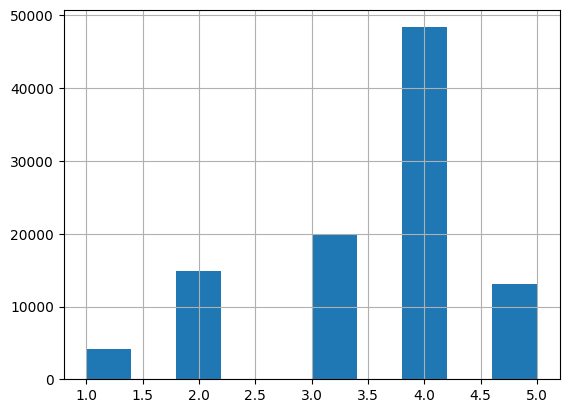

In [13]:
import matplotlib.pyplot as plt

plt.figure(dpi=100)
df.rating.hist()

plt.show()

In [14]:
unique_users = df.userId.unique().tolist()
len(unique_users)

596

In [15]:
unique_users_map = {}

for idx, mm in enumerate(df.userId.unique()):
    unique_users_map[int(mm)] = idx
len(unique_users_map)

596

In [16]:
movie_ids_map = {}

for idx, mm in enumerate(df.movieId.unique()):
    movie_ids_map[mm] = idx
len(movie_ids_map)

9724

# Prepare Train Matrix

In [17]:
import numpy as np
import random
random.seed(42)
np.random.seed(42)

X = np.zeros((len(unique_users), len(movie_ids_map)))

KNOWN_MASK = np.zeros(X.shape) * False
for row in df.itertuples():
    
    # given we have matrix, add in the actual ratings to the matrix
    x = unique_users_map[int(row.userId)]
    y = movie_ids_map[row.movieId]
    X[x, y] = row.rating
    
    # save the coordinates (row, column) of the ratings.
    KNOWN_MASK[x,y] = True

In [18]:
from math import ceil
import scipy.sparse as ss

X_train = X.copy()
test_size = 0.1

num_known = len(np.argwhere(KNOWN_MASK))
num_test = ceil(num_known * test_size)
print(
    "Num. Test:", num_test, "\n",
    "Num. Known:", len(np.argwhere(KNOWN_MASK)))

removed_cords = random.sample(list(enumerate(np.argwhere(KNOWN_MASK))), num_test)
for idx, (x, y)  in removed_cords:
    X_train[x, y] = 0
    KNOWN_MASK[x,y] = False

print("Num. Known:", len(np.argwhere(KNOWN_MASK)))
assert len(np.argwhere(KNOWN_MASK)) == num_known - num_test

Num. Test: 10056 
 Num. Known: 100556
Num. Known: 90500


In [19]:
X_train = X_train.astype("float32")
X = X.astype("float32")
X_train_ss = ss.csr_matrix(X_train)

# RNMFk

In [20]:
from TELF.factorization import NMFk
from TELF.factorization import RNMFk_predict

known_rows, known_columns = np.argwhere(KNOWN_MASK)[:,0], np.argwhere(KNOWN_MASK)[:,1]
params = {
    "n_perturbs":2,
    "n_iters":100,
    "epsilon":0.015,
    "n_jobs":4,
    "init":"nnsvd", 
    "use_gpu":True,
    "save_path":"../../results/", 
    "save_output":True,
    "collect_output":True,
    "predict_k":True,
    "predict_k_method":"sill",
    "verbose":True,
    "nmf_verbose":False,
    "transpose":False,
    "sill_thresh":0.7,
    "pruned":False,
    'nmf_method':'nmf_recommender', # nmf_fro_mu, nmf_recommender
    "calculate_error":True,
    "predict_k":True,
    "use_consensus_stopping":0,
    "calculate_pac":False,
    "perturb_type":"uniform",
    "nmf_obj_params":{
        "lr_bu":0.00001, 
        "lr_bi":0.00001,
        "KNOWN_MASK":(known_rows, known_columns)
    },
    "perturb_multiprocessing":False,
    "perturb_verbose":False
}
Ks = range(1,11,1)
name = "RNMFk_Example"
note = "This is an example run of NMFk"

model = NMFk(**params)

n_perturbs: 2
perturb_type: uniform
n_iters: 100
epsilon: 0.015
init: nnsvd
save_path: ../../results/
save_output: True
use_gpu: False
verbose: True
nmf_verbose: False
perturb_verbose: False
transpose: False
collect_output: True
sill_thresh: 0.7
predict_k: True
predict_k_method: sill
n_jobs: 4
n_nodes: 1
nmf: <function nmf at 0x17dcd11c0>
nmf_method: nmf_recommender
nmf_obj_params: {'lr_bu': 1e-05, 'lr_bi': 1e-05, 'KNOWN_MASK': (array([  0,   0,   0, ..., 595, 595, 595]), array([   0,    1,    2, ..., 1718, 1961, 1978]))}
pruned: False
calculate_error: True
consensus_mat: False
use_consensus_stopping: 0
mask: None
calculate_pac: False
simple_plot: True
get_plot_data: False
perturb_multiprocessing: False
total_exec_seconds: 0
experiment_name: 
nmf_params: {'niter': 100, 'use_gpu': False, 'nmf_verbose': False, 'lr_bu': 1e-05, 'lr_bi': 1e-05, 'KNOWN_MASK': (array([  0,   0,   0, ..., 595, 595, 595]), array([   0,    1,    2, ..., 1718, 1961, 1978]))}


/Users/maksim/miniconda3/envs/TELF_public/lib/python3.11/site-packages/TELF-0.0.1-py3.11.egg/TELF/factorization/NMFk.py:590: UserWarning: calculate_error is True! Error calculation can make the runtime longer and take up more memory space!
/Users/maksim/miniconda3/envs/TELF_public/lib/python3.11/site-packages/TELF-0.0.1-py3.11.egg/TELF/factorization/utilities/organize_n_jobs.py:10: UserWarning: No GPU found! Using CPUs


In [21]:
%time results = model.fit(X_train_ss, Ks, name, note)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/maksim/miniconda3/envs/TELF_public/lib/python3.11/site-packages/numpy-1.26.2-py3.11-macosx-11.1-arm64.egg/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/maksim/miniconda3/envs/TELF_public/lib/python3.11/site-packages/numpy-1.26.2-py3.11-macosx-11.1-arm64.egg/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10/10 [01:00<00:00,  6.10s/it]

CPU times: user 3min 2s, sys: 7.72 s, total: 3min 9s
Wall time: 1min 1s


In [22]:
results.keys()

dict_keys(['time', 'k_predict', 'W', 'H', 'other_results'])

In [23]:
results["k_predict"]

10

# Define Prediction Helper

In [24]:
W = results["W"]
H = results["H"]
global_mean = results["other_results"]["global_mean"]
bi = results["other_results"]["bi"]
bu = results["other_results"]["bu"]

In [25]:
y_preds_test = []
y_trues_test = []
for idx, (u, i) in removed_cords:
    y_preds_test.append(RNMFk_predict(W, H, global_mean, bu, bi, u, i))
    y_trues_test.append(X[u, i])
    
y_preds_test = np.array(y_preds_test)
y_trues_test = np.array(y_trues_test)

In [26]:
rows, columns = np.argwhere(KNOWN_MASK)[:,0], np.argwhere(KNOWN_MASK)[:,1]

y_preds_train = []
y_trues_train = []

for u, i in zip(rows, columns):
    y_preds_train.append(RNMFk_predict(W, H, global_mean, bu, bi, u, i))
    y_trues_train.append(X_train_ss[u, i])
    
y_preds_train = np.array(y_preds_train)
y_trues_train = np.array(y_trues_train)

In [27]:
from sklearn.metrics import mean_squared_error

reconstruct = mean_squared_error(W@H, X_train, squared=True)
mse_train = mean_squared_error(y_preds_train, y_trues_train, squared=True)
mse_test = mean_squared_error(y_preds_test, y_trues_test, squared=True)

print("NMF reconstruction error:", reconstruct)
print("NMF train error:", mse_train)
print("NMF test error:", mse_test)

NMF reconstruction error: 0.18790582
NMF train error: 0.9238482205984361
NMF test error: 0.9474772898879747
